# Efficient Pyspark Case Study

## TLDR

- PandasUDF was fastest, though the non-JOIN options all did similarly well
- the JOIN BETWEEN took ~ 1000 times longer! (equi-JOIN was ten times faster than this)
- computing 30 columns didn't take much longer than 1 column for non-JOIN options
- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NHSDigital/rap-community-of-practice/blob/main/docs/training_resources/pyspark/efficient-pyspark-case-study.ipynb "Open the code in Google Colab") and **play with the code straight away**

## Introduction

There are a load of different ways we can do row-wise analyses in Pyspark -
lets see how a number of common approach compare.

In this guide we will make 10,000,000 rows of fake data full of "ages", and
then try following techniques on 1, 10 and 30 columns to see how long they
take, and ultimately crown one, the champion.

Consider also checking out our recommended **[Pyspark Style Guide][1]**.

**Techniques**:

- CASE WHEN
- pandas UDF - pandas.cut
- UDF - if then else
- JOIN BETWEEN
- equi-JOIN

**Author**: NHS Digital Data Science Squad

[1]: pyspark-style-guide.md

## Setup

### Spark Setup

First a bit of code to make this work using PySpark in Google Colab. Basically
it just installs PySpark and makes the spark session

In [ ]:
try: # this is wrapped in a try except so that if it fails
     # (i.e. it's not run in colab, such as in databricks) this will catch it.
  import google.colab
  IN_COLAB = True
  %pip install pyspark # in Colab we need to install pyspark
except:
  IN_COLAB = False

In [2]:
if IN_COLAB: # in colab we also need to make the Spark session
             # (in Databricks this comes premade)
    from pyspark.sql import SparkSession

    spark = (SparkSession
    .builder
    .master("local")
    .appName("Colab")
    .config('spark.ui.port', '4050')
    .getOrCreate()
    )

### Import Modules

We need to import all the functions etc. that we will use

In [3]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import (pandas_udf, PandasUDFType, lit,
                                   col, when,array, split, explode,
                                   isnull, udf)

### Get Data

First we need 10,000,000 rows of data to test the functions on. You can find a
function and code snippet to generate this below.

The reason why this is a quite complicated, is that to get the truest performance we
need a table, on the disk (not some data held in memory), hence the code below
has a lot of extra bits to make sure it writes to the disk. To allow us to write
large tables, it does it in batches (this means we could make a table of any size
and really heavily test these approaches.

In [4]:
import pandas as pd

def make_random_dataset(database='default', number_of_feature_cols = 30,
                        number_of_rows = 10000000, batch_size = 1000000,
                        column_name_root = 'AGE', table_name = 'random_dataset'):
    """Make a dataset (in a table) with random values between 0 and 120 with
    the specified number_of_rows and feature columns and a patient_id field.
  
    Returns a pyspark dataframe of the dataset (and there will also be a hard
    table of the dataset made)

    Parameters
    ----------
    database : str
    number_of_feature_cols : int
    number_of_rows : int
    batch_size : int
    column_name_root : str
    table_name : str
    Returns
    -------
    sdf_random_dataset : pyspark.DataFrame

    Examples
    --------
    >>> sdf_random_dataset = make_random_dataset()
    >>> sdf_random_dataset.count()
    10000000
    """

    # use a list comprehension to generate a list of "Age column" names
    column_list = [f'{column_name_root}{x}'
                   for x in range(0,number_of_feature_cols)]
    # we do it in batches to avoid using too much memory, so this works out
    # the batch size
    number_of_batches = int(number_of_rows / batch_size)
    # use the Numpy randint function to generate an array full of
    # random integers
    npa_random = np.random.randint(0,120,size=(batch_size,
                                               number_of_feature_cols)
                                   )
    # make this into a pandas dataframe
    df_random_dataset = (pd.DataFrame(npa_random, columns=column_list)
                         .rename_axis(index='patient_id')
                         .reset_index()
                         )
    # finally make this into a spark dataframe
    sdf_random_dataset = spark.createDataFrame(df_random_dataset)
    # now for each batch write the data into a table we defined
    for batch in range(0, number_of_batches-1):
        if batch == 0: 
            mode="overwrite" # on the first loop we want it to overwrite
                             # what is there
        else: 
            mode="append" # subsequent loops we want it to add each batch
        (sdf_random_dataset
        .write.mode(mode)
        # the path line might need changing (or just removing) in databricks
        .option("path",f"file:///content/spark-warehouse/{database}.{table_name}")
        .format("parquet") # this is just a table file format
        .saveAsTable(f"{database}.{table_name}")
        )
    # return the table as a dataframe so we can use it
    return spark.table(f"{database}.{table_name}")

Drop the `default.random_dataset` table if it already exists and then make the table and get the dataframe of this table (`df_data`)

In [5]:
spark.sql("drop table if exists default.random_dataset");

database = 'default'

df_data = make_random_dataset(database=database, number_of_feature_cols = 30,
                              number_of_rows = 10000000, 
                              batch_size = 1000000,
                              column_name_root = 'AGE', table_name = 'random_dataset',
                              )

age_cols = df_data.drop('patient_id').columns

## Define the methods

### CASE WHEN

[CASE WHEN][2] is perhaps the simplest approach, and most SQL practicioners
will be familiar with this way of doing Agebands or other such tranformations.
In this instance we actually use a blob of SQL to do the CASE WHEN statement!
Here is some guidance on how to do this in both [Spark SQL][3] and [Pyspark][4].

This should be pretty efficient, because pyspark can easily map this across the
whole dataset. Conventionally, doing this for 30 columns in SQL would have a
real pain, however we use python (sring formatting) to basically use this one
set of SQL code for all 30 columns!

[2]: https://spark.apache.org/docs/latest/sql-ref-syntax-qry-select-case.html
[3]: https://spark.apache.org/docs/latest/sql-ref-syntax-qry-select-case.html
[4]: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.when.html?highlight=case%20when

In [6]:
# SQL CASE WHEN is pretty basic -
# CASE WHEN <condition> THEN <result> WHEN <...> THEN <...> etc.
# ELSE <result if all else fails>
sql_ageband_casewhen_string = '''CASE WHEN {0} >= 0 and {0} <=18 THEN '0-18'
  WHEN {0} >= 19 and {0} <=30 THEN '19-30'
  WHEN {0} >= 31 and {0} <=39 THEN '31-39'
  WHEN {0} >= 40 and {0} <=49 THEN '40-49'
  WHEN {0} >= 50 and {0} <=59 THEN '50-59'
  WHEN {0} >= 60 and {0} <=69 THEN '60-69'
  WHEN {0} >= 70 and {0} <=79 THEN '70-79'
  WHEN {0} >= 80 and {0} <=89 THEN '80-89'
  WHEN {0} >= 90 and {0} <=150 THEN '90+' END as {0}_band'''

# At the end we want to run the above SQL script against all the age columns
# and against all values in those columns. We use a "selectExpr" that allow us
# submit SQL to the spark dataframe `df_data`
def selectExpr_sql_ageband_casewhen(df_data=df_data, age_cols=age_cols):
    # first we need to get a copy of the casewhen statement for each age column
    case_when_sql_for_each_column = [sql_ageband_casewhen_string.format(col)
                                     for col in age_cols]
    # then use selectExpr to apply it to the dataframe
    return df_data.selectExpr("*", *case_when_sql_for_each_column)

# We also wanted to see if doing this using pure SQL had an effect
# so the below is the same as the above, but rather than using "selectExpr"
# it just makes a SQL query and executes that against the table (which
# df_data also points to.
def spark_sql_ageband_casewhen(df_data=df_data, age_cols=age_cols):
    case_when_sql_for_each_column = [sql_ageband_casewhen_string.format(col)
                                     for col in age_cols]
    return spark.sql("SELECT "
                     +",".join(['*']+case_when_sql_for_each_column)
                     +f" FROM default.random_dataset"
                     )

### UDF

["User Defined Functions" (UDFs)][5] are a way of taking a normal Python
function, and mapping it across the rows in the Pyspark dataframe.
This shouldn't be the fastest because the programme needs to convert the python
code into the underlying language that spark uses.

In this instance, our Python code uses "if..else" logic, so not unlike CASE
WHEN.

You can see guidance on UDFs [here][6].

[5]: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.udf.html#pyspark.sql.functions.udf
[6]: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.udf.html#pyspark.sql.functions.udf

In [7]:
# made the python function for age band
# simply takes and integer and age and outputs
# the corresponding age band
def ageband_func(age: int) -> str:
  if 0 <= age <= 18: return '0-18'
  elif 19 <= age <= 30: return '19-30'
  elif 31 <= age <= 39: return '31-39'
  elif 40 <= age <= 49: return '40-49'
  elif 50 <= age <= 59: return '50-59'
  elif 60 <= age <= 69: return '60-69'
  elif 70 <= age <= 79: return '70-79'
  elif 80 <= age <= 89: return '80-89'
  elif 90 <= age <= 150: return '90+'
  elif age is None: return None

# we then need to convert into a UDF so pyspark can use it
ageband_udf = udf(ageband_func)

# now we will make a little wrapper function which will
# apply this UDF to all the ageband columns in df_data
def udf_ageband(df_data=df_data, age_cols=age_cols):
  return df_data.select("*",
                        *[ageband_udf(col).alias(f"{col}_band")
                          for col in age_cols]
                        )

### Pandas UDF

The ["Pandas User Defined Function" (PandasUDF)][7] is somewhat like a UDF,
except it uses Apache arrow to transfer data and Pandas to actually work with
the data which allows vectorised operations, speeding things up. (Pandas uses
Numpy, which is veeeery efficient).

In this instance, our PandasUDF is using the [`pandas.cut`][8]
function to split the data into buckets for each age.

This could be amongst the fastest approaches, but it also a bit fiddly to set
up and understand (though not so bad once you understand it!)

You can see more guidance on using the new Spark 3.0 PandasUDFs [here][9] or an
older blog on PandasUDFs [here][10].

[7]: https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.functions.pandas_udf.html
[8]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
[9]: https://www.databricks.com/blog/2020/05/20/new-pandas-udfs-and-python-type-hints-in-the-upcoming-release-of-apache-spark-3-0.html
[10]: https://www.databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html

In [ ]:
# the syntax of pandas UDF is a little more complicated than UDF
# first we need this decorator (@...) which tells spark
# what to expect from the function, in this case a string
# output and it takes scalar values
@pandas_udf('string', PandasUDFType.SCALAR)
def ageband_cut(age_series : pd.Series(str)) -> pd.Series:
  # internally it is very simple, just the pandas "cut" function
  # which assigns pandas series elements to buckets (labels)
  return pd.cut(age_series,[0, 19, 31, 40, 50, 60, 70, 80, 90, 1000],
                labels=['0-18','19-30', '31-39', '40-49', '50-59',
                        '60-69', '70-79', '80-89', '90+'],
                retbins=False, right=False)

# as in the UDF, we now just need a little wrapper function
# to apply the pandas UDF to all of the age columns in df_data
def pandas_udf_cut_ageband(df_data=df_data, age_cols=age_cols):
  return df_data.select("*",
                        *[ageband_cut(col).alias(f"{col}_band")
                          for col in age_cols]
                        )

### JOIN - BETWEEN

Making a table of ageband reference data and then JOINing this on perhaps the
go-to way that data managers might approach this problem.

However, in Pyspark, JOINs are a "wide" operation, which are generally not as
efficient as "long" operations (such as CASE WHEN / UDF / Pandas UDF).

First we need to make the `agegroup_lookup` reference data table, which has an
`upper_age`, `lower_age` and corresponding `age_group`.

In [9]:
# first we make a agegroup lookup dataframe
agegroup_lookup = pd.DataFrame([
    dict(lower_age = 0, upper_age=18, age_group='0-18'),
    dict(lower_age = 19, upper_age=30, age_group='19-30'),
    dict(lower_age = 31, upper_age=39, age_group='31-39'),
    dict(lower_age = 40, upper_age=49, age_group='40-49'),
    dict(lower_age = 50, upper_age=59, age_group='50-59'),
    dict(lower_age = 60, upper_age=69, age_group='60-69'),
    dict(lower_age = 70, upper_age=79, age_group='70-79'),
    dict(lower_age = 80, upper_age=89, age_group='80-89'),
    dict(lower_age = 90, upper_age=150, age_group='90+')
])

# then we make it a spark dataframe and save it to a table for
# good measure (this was incase we wanted to do SQL against it
sdf_agegroup_lookup = spark.createDataFrame(agegroup_lookup)
sdf_agegroup_lookup.createOrReplaceGlobalTempView('agegroup_lookup')

There are a few ways we can approach JOINs. The most obvious way is to simply
use BETWEEN to check for each record, if the age is between the upper and lower
ages described in the lookup and then return the agegroup.

This probably won't be very efficient, because "non-equi-JOINs" (i.e. JOINs
without an "=" within the ON statement) do an implicit CROSS JOIN and so aren't
very efficient.

In [10]:
def chain_join_between_ageband(df_data=df_data, age_cols=age_cols):
  df_data_ageband_join = df_data
  # this code (probably not an example of best practice!) loops
  # over each of the columns and then JOINs on the lookup to
  # work out the ageband
  for col in age_cols:
    df_data_ageband_join = (df_data_ageband_join
        .join(sdf_agegroup_lookup,
              # this is the BETWEEN bit
              (df_data[col] >= sdf_agegroup_lookup['lower_age'])
              & (df_data[col] <= sdf_agegroup_lookup['upper_age']),
              how='left'
              )
        .withColumnRenamed('age_group',f"{col}_band")
        # we only care about the ageband, so drop the rest of the
        # lookup columns
        .drop('lower_age', 'upper_age')
        )
  return df_data_ageband_join

### equi-JOIN

The less obvious way to do JOINs is to un-pivot the reference data, so that it
is very long (i.e. age 11 means ageband 10-20), then we can join using an "="
in the ON statement (called an equi-JOIN). This should be a lot more efficient
than the non-equi-JOIN.

In [11]:
# first we make a little function to work out the ages that compose each
# age band, as a list
ageband_ages_list = lambda x: list(range(x['lower_age'],x['upper_age']+1))
# now we apply this to the agegroup dataframe to make a new column
# containing a list of ages for each agegroup
agegroup_lookup['age'] = agegroup_lookup.apply(ageband_ages_list,axis=1)
# now we "explode" this age column, which means that a new row is made for
# each element in the lists in the age column - this makes the lookup longer
# as we end up with one row for each age, and the corresponding ageband
agegroup_lookup_explode = agegroup_lookup.set_index('age_group').explode('age')['age']
# make into a spark dataframe and a global temp view
sdf_agegroup_lookup_long = spark.createDataFrame(agegroup_lookup_explode.reset_index())
sdf_agegroup_lookup_long.createOrReplaceGlobalTempView('agegroup_lookup_long')

# we then apply it pretty much the same as the BETWEEN
def chain_join_long_ageband(df_data=df_data, age_cols=age_cols):
  df_data_ageband_join = df_data
  for col in age_cols:
    # this code (probably not an example of best practice!) loops
    # over each of the columns and then JOINs on the lookup to
    # work out the ageband
    df_data_ageband_join = (df_data_ageband_join
                            .join(sdf_agegroup_lookup_long,
                                  # this is the "equal" bit - no need for BETWEEN
                                  df_data[col]==sdf_agegroup_lookup_long['age'],
                                  how='left')
                            .withColumnRenamed('age_group',f"{col}_band")
                            # we only care about the ageband,
                            # so drop the age lookup column
                            .drop('age')
                            )
  return df_data_ageband_join

### Timing functions

Now we have a bit of code to compare how quickly the different approaches ran.

The functions made above all output the original dataframe with these new
ageband columns on the end, so when force them to output results, the spark
will start flowing data and we can see how long it takes.

The functions below runs the different approaches (just doing a count on the
dataframe) a specified number of times and takes the average of the time it
took for each run.

In [12]:
def time_function(func, *args):
    """start timing, run the function, when its done,
    stop the time and work out the difference
    between start and end time"""
    import time 
    t1 = time.time()
    result = func(*args)
    t2 = time.time()
    total_time = t2-t1
    return total_time, result

In [13]:
def avg_time_function(iters, func, *args):
    """Times it 'iters' times, and then
    gets the average"""
    total_time = 0
    for _ in range(iters):
        time, _ = time_function(func, *args)
        total_time += time
    return (total_time/iters)

In [14]:
def process_df(df):
    """This little function forces the spark
    dataframe to run by doing 'count'"""
    df_count = df.count()
    return df, df_count

In [15]:
def print_avg(num_iterations, data_df=df_data, age_cols=age_cols):
    num_rows = data_df.count()
    # to cut down on code we made a dict of the common inputs
    function_inputs = dict(df_data=data_df, age_cols=age_cols)
    # a list of all of the approaches we want to try
    methods_list = [selectExpr_sql_ageband_casewhen,
                    spark_sql_ageband_casewhen,
                    udf_ageband,
                    pandas_udf_cut_ageband,
                    chain_join_long_ageband,
                    chain_join_between_ageband
                    ]
    results = []
    # loop over the approaches:
    for func in methods_list:
        # get the name of the function so we can add it to the plot
        name = str(func.__name__)
        # put the inputs (df_data, and a list of age columns) into
        # the function for the approach
        df = func(**function_inputs)
        # now we "run" the dataframe (using "count") 5 times
        # to get the average time of each approach
        average_run_time = avg_time_function(num_iterations, process_df, df)
        print("average run_time for {name} with {num_rows} rows is {average_run_time}"
              .format(name=name,
                      average_run_time=average_run_time,
                      num_rows=num_rows
                      )
              )
        # add the results dictionary for this run
        # to the list of results
        results.append(dict(name=name,
                            num_cols=len(age_cols),
                            num_rows=num_rows,
                            average_run_time=average_run_time)
                       )
    # convert results (a list of dictionaries) to a dataframe
    # and we are left with a table of results!
    return pd.DataFrame(results)

## Run everything

Now we run the `print_avg` function over the three sets of amounts of age columns, i.e. 1, 10 and 30, and we will get our results!

The code below is very compact, however it uses a list comprehension to and pd.concat to combine the results of the average run time, for each approach, for each amount of age columns into one table of results

In [16]:
df_results = pd.concat([print_avg(5, age_cols=age_cols[:num_cols])
                        for num_cols in [1,10,30]
                        ],
                       axis=0
                       )

average run_time for selectExpr_sql_ageband_casewhen with 9000000 rows is 0.3618640422821045
average run_time for spark_sql_ageband_casewhen with 9000000 rows is 0.36986422538757324
average run_time for udf_ageband with 9000000 rows is 0.27346434593200686
average run_time for pandas_udf_cut_ageband with 9000000 rows is 0.27601003646850586
average run_time for chain_join_long_ageband with 9000000 rows is 4.865589380264282
average run_time for chain_join_between_ageband with 9000000 rows is 1.3739787101745606
average run_time for selectExpr_sql_ageband_casewhen with 9000000 rows is 0.17872200012207032
average run_time for spark_sql_ageband_casewhen with 9000000 rows is 0.19225549697875977
average run_time for udf_ageband with 9000000 rows is 0.18843164443969726
average run_time for pandas_udf_cut_ageband with 9000000 rows is 0.1556694507598877
average run_time for chain_join_long_ageband with 9000000 rows is 9.888206958770752
average run_time for chain_join_between_ageband with 9000000 r

## Results

We averaged the timings over 5 runs, for 1, 10 and 30 age columns. Below we can
see the results, either as a table or as a plot (**note the log scale!**).

In [17]:
df_results

,name,num_cols,num_rows,average_run_time
0,selectExpr_sql_ageband_casewhen,1,9000000,0.361864
1,spark_sql_ageband_casewhen,1,9000000,0.369864
2,udf_ageband,1,9000000,0.273464
3,pandas_udf_cut_ageband,1,9000000,0.276010
4,chain_join_long_ageband,1,9000000,4.865589
5,chain_join_between_ageband,1,9000000,1.373979
0,selectExpr_sql_ageband_casewhen,10,9000000,0.178722
1,spark_sql_ageband_casewhen,10,9000000,0.192255
2,udf_ageband,10,9000000,0.188432
3,pandas_udf_cut_ageband,10,9000000,0.155669


The **key findings**:

- for the more efficient approaches, 1, 10 or 30 columns didn't make much
  difference
- For 30 columns, the equi-JOIN was 100 times slower than the fastest, whilst
  the non-equi-JOIN was a **1000 times slower!**
- UDFs, PandasUDFs, SQL/pyspark all did similarly well, but **PandasUDF** was
  the fastest.

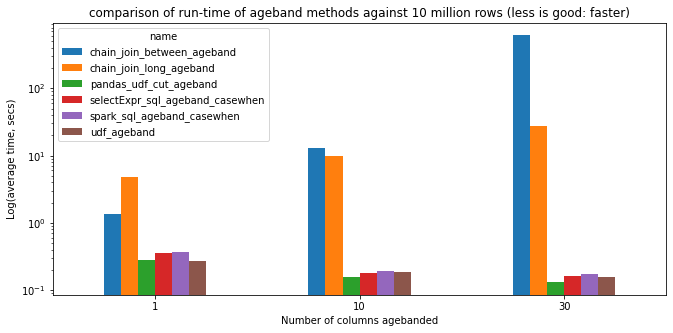

In [18]:
(df_results
 .set_index(['num_cols','name'])
 .unstack()['average_run_time']
 .plot.bar(figsize=(11,5),
             logy=True,
             rot=0,
             title='comparison of run-time of ageband methods against 10 million rows (less is good: faster)',
             ylabel='Log(average time, secs)',
             xlabel='Number of columns agebanded'
            )
 );